In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Bayesian
# ==============================================================================
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold
from sklearn.metrics import classification_report
import xgboost as xgb
from collections import Counter
import time
import optuna
from optuna.samplers import TPESampler
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

# Bayesian Multiobjetivo
# ==============================================================================
import pickle
import sys
import warnings

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

/Users/Cristobal/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#carga los datos
tabla_final = pd.read_csv('Tabla_final_colab.csv', sep = ",")


## Se borran columnas irrelevantes ##
tabla_final = tabla_final.drop('FECHA_DATO', axis=1)
tabla_final = tabla_final.drop('FECHA_PROCESO', axis=1)
tabla_final = tabla_final.drop('ID_PROD', axis=1)
tabla_final = tabla_final.drop('FLAG_PREAP', axis=1)

## Definimos una tabla con los id de clientes
## Para luego poeder funtarla con las prob ##
## Si se queda se considera como parametro ##
tabla_con_id_cliente = tabla_final

tabla_final = tabla_final.drop('ID_CLIENTE', axis=1)
#visualizamos los datos
tabla_final

,CT_CTE,DEBITO_DIR,ID_EMPLEADO,ID_SEGMENTO_VALOR,ANTIGUEDAD,RENTA,EDAD,EDAD_PUNTAJE,ID_GENERO,ACEPTADO
0,1.0,0.0,0.0,2.0,6.0,87218.10,36.0,3.0,1.0,0.0
1,1.0,0.0,0.0,1.0,35.0,122179.11,23.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,35.0,119775.54,23.0,1.0,1.0,0.0
3,1.0,0.0,0.0,1.0,35.0,22220.04,24.0,1.0,1.0,0.0
4,1.0,0.0,0.0,1.0,35.0,295590.36,24.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
602555,0.0,0.0,0.0,2.0,62.0,97397.16,41.0,6.0,1.0,0.0
602556,0.0,0.0,0.0,2.0,7.0,168445.62,34.0,2.0,0.0,0.0
602557,0.0,0.0,0.0,1.0,6.0,53689.02,24.0,1.0,1.0,0.0
602558,0.0,0.0,0.0,2.0,229.0,64404.21,61.0,7.0,0.0,0.0


In [3]:
# Split the data into features (X) and target (y)
X = tabla_final.drop('ACEPTADO', axis=1)
y = tabla_final['ACEPTADO']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
# Bayesian Multiobjetivo
# ==============================================================================
def train(trial):
    
    max_depth = trial.suggest_int('max_depth', 5, X_train.shape[1]) #profundidad máxima del árbol
    n_estimators=trial.suggest_int('n_estimators',125, 200) #número de ramas en el árbol
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20) #mínimo de muestras en el nodo para que se pueda dividir
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20) #mínimo de muestras en un nodo para que sea considerado una hoja
    min_impurity_decrease  = trial.suggest_float('min_impurity_decrease', 0, 1) #mínimo para supervisar si es necesario separar un nodo.
    
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, min_samples_split= min_samples_split, min_samples_leaf=min_samples_leaf, min_impurity_decrease=min_impurity_decrease))
    ])
    
    pipeline.fit(X_train, y_train)
    score = cross_val_score(pipeline, X_train, y_train, scoring='accuracy',
                            cv=4).mean()
    y_pred = pipeline.predict(X_test)
    precision = precision_score(y_test, y_pred)
    

    return score, precision


motpe_sampler = optuna.samplers.MOTPESampler()
motpe_experiment = optuna.create_study(sampler=motpe_sampler, directions="maximize")
motpe_experiment.optimize(train, n_trials=20)

/var/folders/4f/dbgwrrz13h1_vh4b2d4htbn80000gn/T/ipykernel_3599/3789682896.py:26: FutureWarning: MOTPESampler has been deprecated in v2.9.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.9.0.
  motpe_sampler = optuna.samplers.MOTPESampler()
[I 2023-06-22 19:24:11,397] A new study created in memory with name: no-name-94edd807-431f-4f7c-8b44-b51f2108bd2a
/Users/Cristobal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-06-22 19:24:43,716] Trial 0 finished with values: [0.9263662539830058, 0.0] and parameters: {'max_depth': 5, 'n_estimators': 172, 'min_samples_split': 6, 'min_samples_leaf': 20, 'min_impurity_decrease': 0.358883648682501}. 
/Users/Cristobal/Library/Python/3.9/lib/python/site-pa

In [11]:
def cast_as_df(optuna_experiment, experiment_type):
    df = (
        optuna_experiment
        .trials_dataframe()
        .rename(columns={"values_0": "accuracy", "values_1": "precision"})
        .assign(experiment = experiment_type)
    )
    # the following lines create a column identifing which of the trials resulted in a
    # Best configuration -- a model with these HPs lies along the empirical Pareto frontier
    best_trials = [trial.number for trial in optuna_experiment.best_trials]
    df['best_trial'] = np.where(df.number.isin(best_trials), 1, 0)
    return df

motpe_df = cast_as_df(motpe_experiment, "MOTPE")
motpe_df

,number,accuracy,precision,datetime_start,datetime_complete,duration,params_max_depth,params_min_impurity_decrease,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state,experiment,best_trial
0,0,0.926366,0.0,2023-06-22 19:24:11.399024,2023-06-22 19:24:43.716441,0 days 00:00:32.317417,5,0.358884,20,6,172,COMPLETE,MOTPE,1
1,1,0.926366,0.0,2023-06-22 19:24:43.716852,2023-06-22 19:25:10.553789,0 days 00:00:26.836937,6,0.481443,6,15,144,COMPLETE,MOTPE,1
2,2,0.926366,0.0,2023-06-22 19:25:10.554211,2023-06-22 19:25:40.843568,0 days 00:00:30.289357,7,0.087500,13,5,164,COMPLETE,MOTPE,1
3,3,0.926366,0.0,2023-06-22 19:25:40.843977,2023-06-22 19:26:13.732133,0 days 00:00:32.888156,9,0.125006,18,12,180,COMPLETE,MOTPE,1
4,4,0.926366,0.0,2023-06-22 19:26:13.732551,2023-06-22 19:26:44.312755,0 days 00:00:30.580204,7,0.927058,6,14,165,COMPLETE,MOTPE,1
5,5,0.926366,0.0,2023-06-22 19:26:44.313175,2023-06-22 19:27:11.186137,0 days 00:00:26.872962,5,0.052487,12,7,145,COMPLETE,MOTPE,1
6,6,0.926366,0.0,2023-06-22 19:27:11.186550,2023-06-22 19:27:41.728255,0 days 00:00:30.541705,5,0.861838,8,8,162,COMPLETE,MOTPE,1
7,7,0.926366,0.0,2023-06-22 19:27:41.728662,2023-06-22 19:28:09.941144,0 days 00:00:28.212482,6,0.472643,12,7,151,COMPLETE,MOTPE,1
8,8,0.926366,0.0,2023-06-22 19:28:09.941520,2023-06-22 19:28:46.223643,0 days 00:00:36.282123,6,0.496176,13,5,194,COMPLETE,MOTPE,1
9,9,0.926366,0.0,2023-06-22 19:28:46.224050,2023-06-22 19:29:10.245210,0 days 00:00:24.021160,7,0.935652,18,9,130,COMPLETE,MOTPE,1


In [19]:
# Bayesian
# ==============================================================================
start_time = time.time()
def objective(trial):
    # Define the search space
    
    max_depth = trial.suggest_int('max_depth', 5, X_train.shape[1]) #profundidad máxima del árbol
    n_estimators=trial.suggest_int('n_estimators',125, 200) #número de ramas en el árbol
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20) #mínimo de muestras en el nodo para que se pueda dividir
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20) #mínimo de muestras en un nodo para que sea considerado una hoja
    min_impurity_decrease  = trial.suggest_float('min_impurity_decrease', 0, 1) #mínimo para supervisar si es necesario separar un nodo.
    
    model = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, min_samples_split= min_samples_split, min_samples_leaf=min_samples_leaf, min_impurity_decrease=min_impurity_decrease)
    
    score = cross_val_score(model, X_train, y_train, scoring='accuracy',
                            cv=4).mean()
    return score
study_DT = optuna.create_study(study_name="dectree_artf",
                            direction="maximize",
                            sampler=TPESampler())
study_DT.optimize(objective, n_trials=20)
print("--- {} minutos para el tuneo---".format((time.time() - start_time)/60))

[I 2023-06-21 14:57:54,045] A new study created in memory with name: dectree_artf
[I 2023-06-21 14:58:23,047] Trial 0 finished with value: 0.9267189159585767 and parameters: {'max_depth': 6, 'n_estimators': 199, 'min_samples_split': 13, 'min_samples_leaf': 8, 'min_impurity_decrease': 0.46156552011521734}. Best is trial 0 with value: 0.9267189159585767.
[I 2023-06-21 14:58:41,945] Trial 1 finished with value: 0.9267189159585767 and parameters: {'max_depth': 6, 'n_estimators': 136, 'min_samples_split': 14, 'min_samples_leaf': 14, 'min_impurity_decrease': 0.21037584162074252}. Best is trial 0 with value: 0.9267189159585767.
[I 2023-06-21 14:59:07,903] Trial 2 finished with value: 0.9267189159585767 and parameters: {'max_depth': 9, 'n_estimators': 179, 'min_samples_split': 17, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.7384010305859254}. Best is trial 0 with value: 0.9267189159585767.
[I 2023-06-21 14:59:47,000] Trial 3 finished with value: 0.9267189159585767 and parameters: {'max_d

--- 8.046020448207855 minutos para el tuneo---


In [20]:
print(study_DT.best_params)

{'max_depth': 6, 'n_estimators': 199, 'min_samples_split': 13, 'min_samples_leaf': 8, 'min_impurity_decrease': 0.46156552011521734}


In [5]:
#param_dist = {'n_estimators': randint(80,120),
#              'max_depth': randint(8,12)}

# Create a random forest classifier
#rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
#rand_search = RandomizedSearchCV(rf, 
#                                 param_distributions = param_dist, 
#                                 n_iter=5, 
#                                 cv=5)

# Fit the random search object to the data
#rand_search.fit(X_train, y_train)

In [6]:
# Create a variable for the best model
#best_rf = rand_search.best_estimator_

# Print the best hyperparameters
#print('Best hyperparameters:',  rand_search.best_params_)

#### Best hyperparameters: {'max_depth': 9} #####

In [7]:
# Generate predictions with the best model
#y_pred = best_rf.predict(X_test)

# Create the confusion matrix
#cm = confusion_matrix(y_test, y_pred)

#ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [8]:
#y_pred = best_rf.predict(X_test)

#accuracy = accuracy_score(y_test, y_pred)
#precision = precision_score(y_test, y_pred)
#recall = recall_score(y_test, y_pred)

#print("Accuracy:", accuracy)
#print("Precision:", precision)
#print("Recall:", recall)

In [9]:
#param_dist = {'n_estimators': randint(80,120)}

# Create a random forest classifier
#rf = RandomForestClassifier(max_depth = 9)

# Use random search to find the best hyperparameters
#rand_search = RandomizedSearchCV(rf, 
#                                param_distributions = param_dist, 
#                                 n_iter=5, 
#                                 cv=5)

# Fit the random search object to the data
#rand_search.fit(X_train, y_train)

In [10]:
# Create a variable for the best model
#best_rf = rand_search.best_estimator_

# Print the best hyperparameters
#print('Best hyperparameters:',  rand_search.best_params_)

##### Best hyperparameters: {'n_estimators': 110} ###

In [22]:
##### Caso con parametros optimos ####

best_rf = RandomForestClassifier(max_depth = 6, n_estimators = 199, min_samples_split= 13, min_samples_leaf=8, min_impurity_decrease=0.46156552011521734)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

In [23]:
#### Indicadores de desempeño ###

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

### CON ID CLIENTE ###
#Accuracy: 0.9387741500729408
#Precision: 0.6155514767228433
#Recall: 0.3821609862218999

### CON TABLA ANTIGUA SIN FILTROS ###
#Accuracy: 0.9370191275242333
#Precision: 0.6259222333000997
#Recall: 0.32135544635544633

Accuracy: 0.925625663834307
Precision: 0.0
Recall: 0.0


/Users/Cristobal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


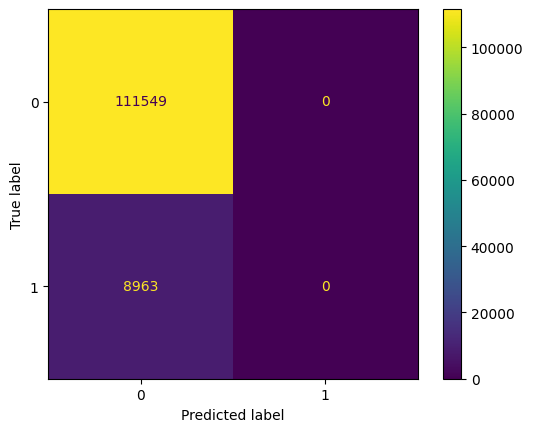

In [24]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

<Axes: >

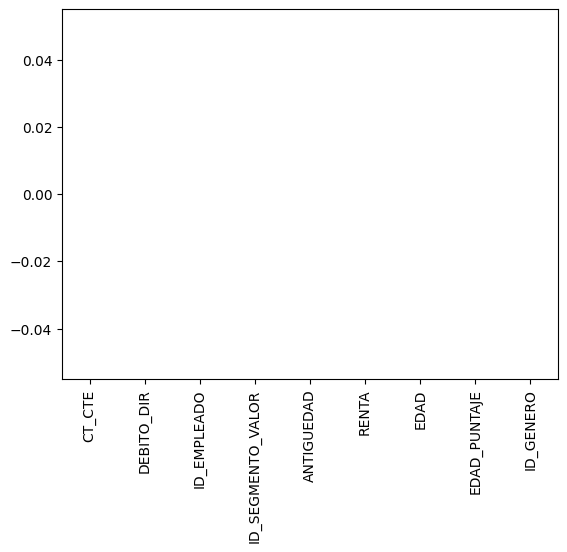

In [25]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

In [26]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [27]:
probabilidades = best_rf.predict_proba(X)
probabilidad_de_aceptar = []

for i in range (0,len(probabilidades)):
    probabilidad_de_aceptar.append(probabilidades[i][1])

df = pd.DataFrame({'probabilidad_de_aceptar':probabilidad_de_aceptar})
df

,probabilidad_de_aceptar
0,0.073251
1,0.073251
2,0.073251
3,0.073251
4,0.073251
...,...
602555,0.073251
602556,0.073251
602557,0.073251
602558,0.073251


In [28]:
tabla_con_id_cliente_mas_probabilidad = pd.merge(tabla_con_id_cliente, df, left_index=True, right_index=True)

tabla_con_id_cliente_mas_probabilidad

,CT_CTE,DEBITO_DIR,ID_EMPLEADO,ID_SEGMENTO_VALOR,ANTIGUEDAD,ID_CLIENTE,RENTA,EDAD,EDAD_PUNTAJE,ID_GENERO,ACEPTADO,probabilidad_de_aceptar
0,1.0,0.0,0.0,2.0,6.0,1375586.0,87218.10,36.0,3.0,1.0,0.0,0.073251
1,1.0,0.0,0.0,1.0,35.0,1050612.0,122179.11,23.0,1.0,0.0,0.0,0.073251
2,0.0,0.0,0.0,1.0,35.0,1050613.0,119775.54,23.0,1.0,1.0,0.0,0.073251
3,1.0,0.0,0.0,1.0,35.0,1050615.0,22220.04,24.0,1.0,1.0,0.0,0.073251
4,1.0,0.0,0.0,1.0,35.0,1050616.0,295590.36,24.0,1.0,1.0,0.0,0.073251
...,...,...,...,...,...,...,...,...,...,...,...,...
602555,0.0,0.0,0.0,2.0,62.0,899549.0,97397.16,41.0,6.0,1.0,0.0,0.073251
602556,0.0,0.0,0.0,2.0,7.0,1441442.0,168445.62,34.0,2.0,0.0,0.0,0.073251
602557,0.0,0.0,0.0,1.0,6.0,1454431.0,53689.02,24.0,1.0,1.0,0.0,0.073251
602558,0.0,0.0,0.0,2.0,229.0,56812.0,64404.21,61.0,7.0,0.0,0.0,0.073251


In [29]:
tabla_con_id_cliente_mas_probabilidad = tabla_con_id_cliente_mas_probabilidad.sort_values(by='probabilidad_de_aceptar', ascending = False)
tabla_con_id_cliente_mas_probabilidad.dropna()

,CT_CTE,DEBITO_DIR,ID_EMPLEADO,ID_SEGMENTO_VALOR,ANTIGUEDAD,ID_CLIENTE,RENTA,EDAD,EDAD_PUNTAJE,ID_GENERO,ACEPTADO,probabilidad_de_aceptar
0,1.0,0.0,0.0,2.0,6.0,1375586.0,87218.10,36.0,3.0,1.0,0.0,0.073251
401719,1.0,1.0,0.0,2.0,105.0,554633.0,73194.36,39.0,4.0,0.0,0.0,0.073251
401703,1.0,1.0,0.0,2.0,118.0,554953.0,93743.91,43.0,8.0,0.0,0.0,0.073251
401704,1.0,0.0,0.0,2.0,118.0,554955.0,143031.21,52.0,7.0,0.0,0.0,0.073251
401705,0.0,1.0,0.0,2.0,118.0,554864.0,66891.33,38.0,4.0,0.0,1.0,0.073251
...,...,...,...,...,...,...,...,...,...,...,...,...
200853,1.0,0.0,0.0,1.0,21.0,1199808.0,92334.45,24.0,1.0,0.0,0.0,0.073251
200854,0.0,0.0,0.0,2.0,21.0,1199811.0,121647.36,39.0,4.0,1.0,0.0,0.073251
200855,1.0,0.0,0.0,1.0,21.0,1199812.0,132640.50,22.0,1.0,0.0,0.0,0.073251
200856,1.0,0.0,0.0,1.0,21.0,1199817.0,44436.18,26.0,1.0,1.0,0.0,0.073251


In [30]:
tabla_con_id_cliente_mas_probabilidad.to_csv(r'C:\Users\marti\Desktop\Capstone\procesamiento de datos\Resultados_Random_Forest.csv', index=False, header=True)